<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
from ydata_profiling import ProfileReport
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import plotly.express as px
import plotly.graph_objects as go
import itertools
from prophet import Prophet
from prophet.diagnostics import cross_validation,performance_metrics
from prophet.plot import plot_cross_validation_metric
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense,LSTM
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split

C:\ana\lib\site-packages\numba\core\decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
C:\ana\lib\site-packages\visions\backends\shared\nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:


In [2]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\ana\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['sqrt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [3]:
try:
    data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
data.sort_index(inplace=True)

resample по часу

In [5]:
data = data.resample('1H').sum()

In [6]:
data

num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43
...                         ...
2018-08-31 19:00:00         136
2018-08-31 20:00:00         154
2018-08-31 21:00:00         159
2018-08-31 22:00:00         223
2018-08-31 23:00:00         205

[4416 rows x 1 columns]

In [7]:
ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

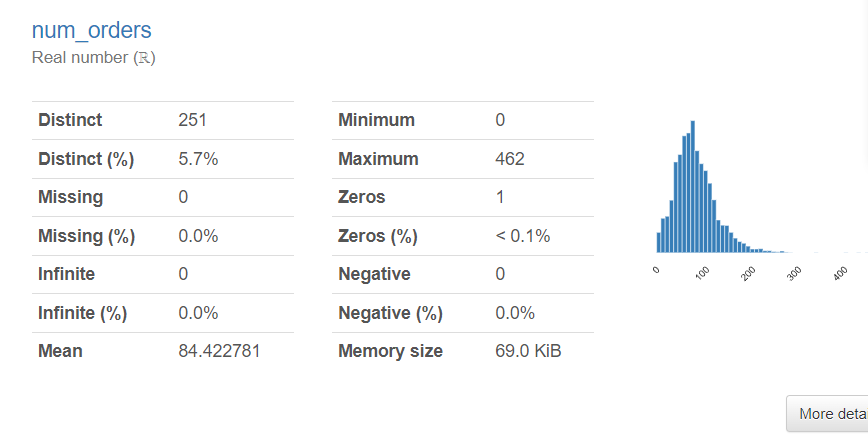

отлично пропусков нет 
<bt>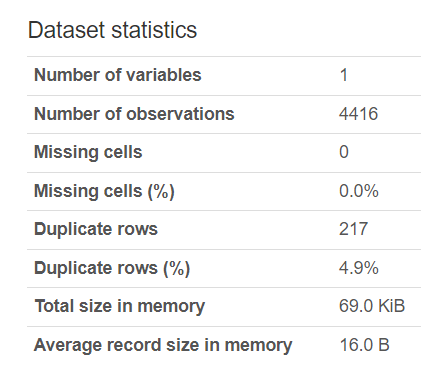


вывод eda: проблем с типом данных нет
<br>временной ряд пропусков не имеет
<br>дубликаты отсутсвуют 
<br>обнаружены странные значения по ночам пик активности в 2 часа ночи , но опять же возможно взята из другого часового пояса данные 
<br>данные не нуждаются в очистке 

## Анализ

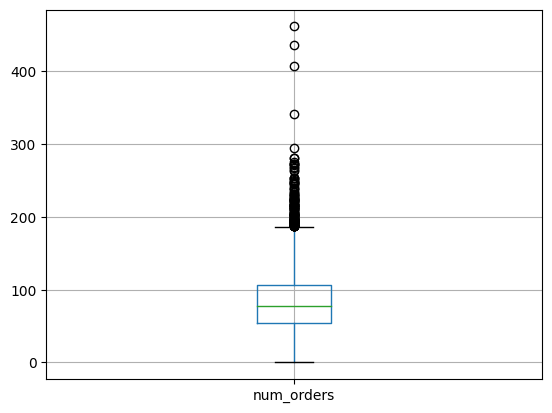

In [8]:
data.boxplot()
plt.show()

boxplot не особо информативен в данной ситуации , просто окинул взгляд

In [9]:
fig = px.line(data, x=data.index, y='num_orders', title='num_orders for all the time')

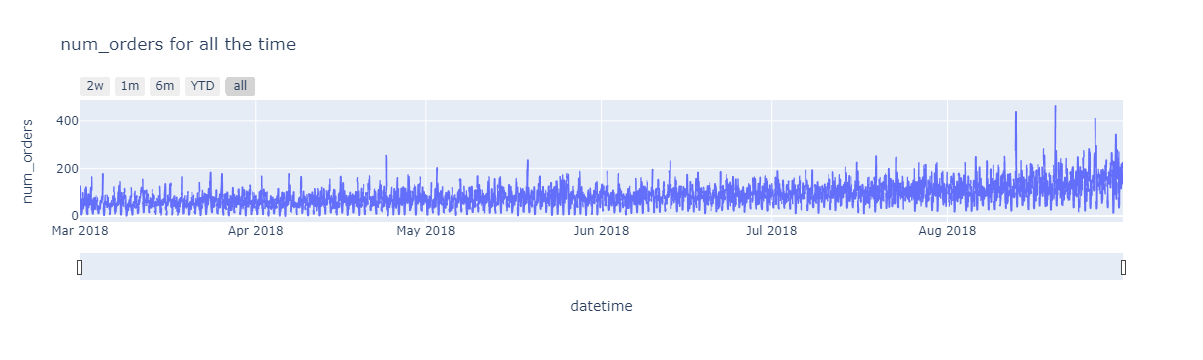

In [10]:
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=14, label="2w", step="day", stepmode="backward"),
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(step="all")
        ])
    )
)
fig.show()


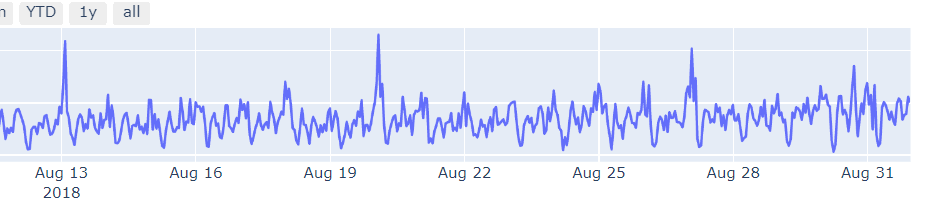

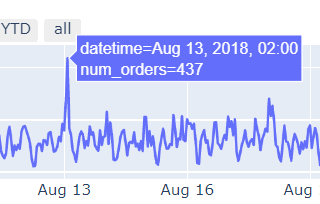

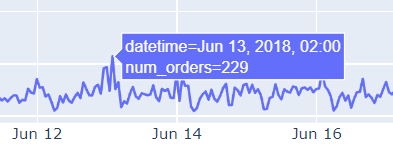
<br>все эти пики ночью , явная аномалия c другой стороны вдруг данные с владивостока, здесь я бы пошёл делать уточнения к заказчику.Но это учебный проект кто заказчик? ответа нет , поэтому будем думать что это выброс 

хотя я изучил подробнее все пики действительно ночью => вывод скорее всего другой часовой пояс анализируем

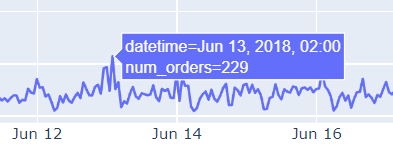

In [11]:
decomposed = seasonal_decompose(data)

In [12]:
fig = px.line(decomposed.trend,decomposed.trend.index, y=[decomposed.trend], title='num_orders for all the time')

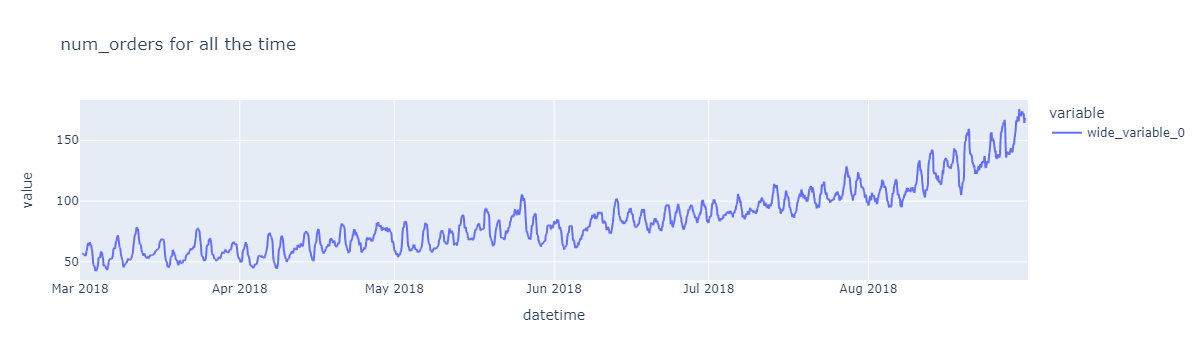

In [13]:
fig.show()

как мне не нравится тренд , слишком резкий 

In [14]:
fig = px.line(decomposed.trend,decomposed.trend.index, y=[decomposed.seasonal], title='num_orders for all the time')

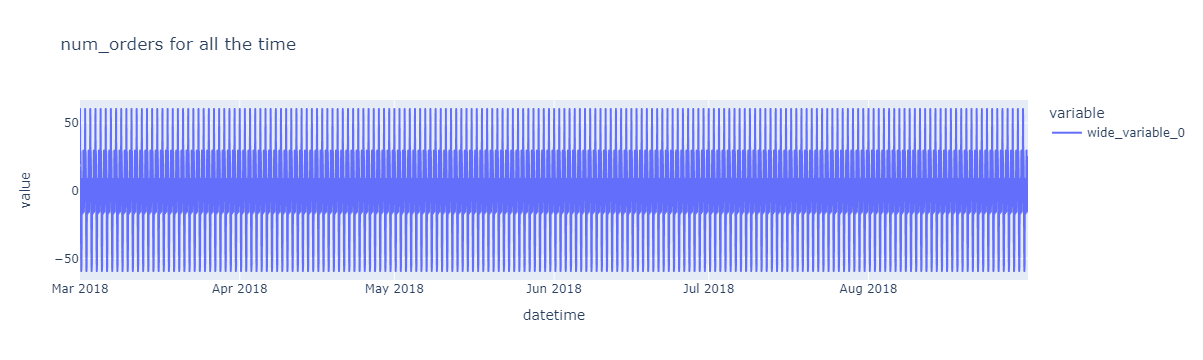

In [15]:
fig.show()

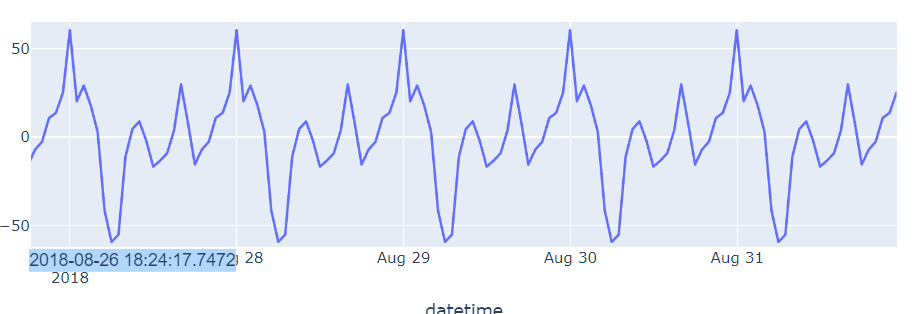

у нас есть какая-то сезонность но я не понял как считавать , мне кажется что почасовая как-раз присутствует

In [16]:
fig = px.line(decomposed.trend,decomposed.trend.index, y=[decomposed.resid], title='num_orders for all the time')

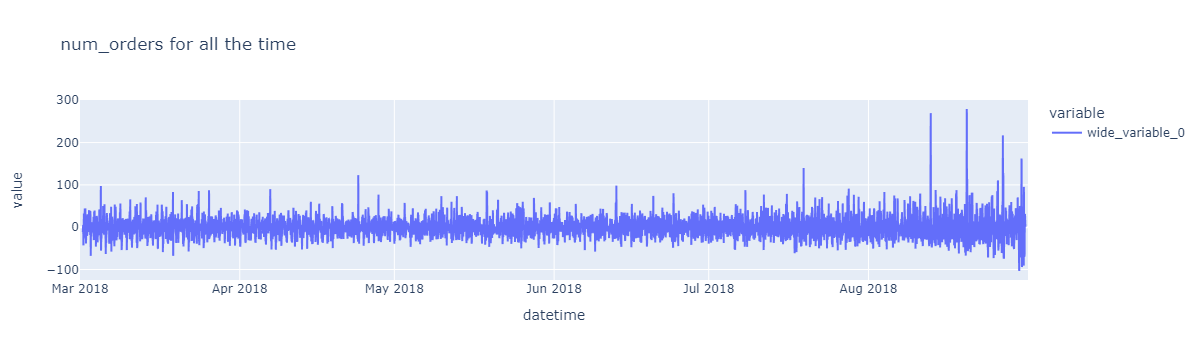

In [17]:
fig.show()

хм это считается шумом ,как раз были вопросы к этим значениям
<br>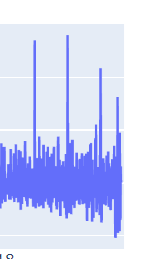

In [18]:
y_tra_va, y_test = temporal_train_test_split(data,test_size = 0.15) #y train ttest
y_train, y_valid = temporal_train_test_split(y_tra_va,test_size = 0.1765) # y test y test test

In [19]:
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(3090, 1)
(663, 1)
(663, 1)


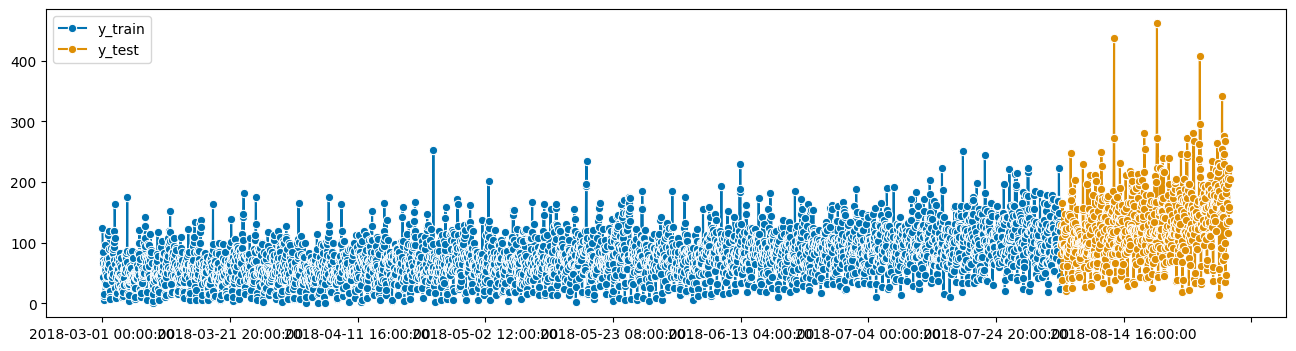

In [20]:
plot_series(y_tra_va.sort_index(), y_test.sort_index(), labels=["y_train", "y_test"]);

ужасный график , но видно что разделило корректно 

In [21]:
# from sktime.forecasting.all import ForecastingHorizon

In [22]:
# fh = ForecastingHorizon(y_test.index, is_relative=False)
# naive_forecaster_seasonal = NaiveForecaster(strategy="last")
# naive_forecaster_seasonal.fit(y_train)
# y_seasonal_last = naive_forecaster_seasonal.predict(fh)
# np.sqrt(mean_squared_error(y_seasonal_last, y_test))

проверка на глупость модели (показало rmse 66), закоментил потому что переопределяло print 

## Обучение

будем использовать профет , подготовка данных для него 

In [23]:
m_train = y_train.reset_index()
m_test = y_valid.reset_index()

In [24]:
m_train.columns = ['ds', 'y']
m_test.columns = ['ds', 'y']

In [25]:
m = Prophet( )
m.fit(m_train)

20:54:29 - cmdstanpy - INFO - Chain [1] start processing
20:54:29 - cmdstanpy - INFO - Chain [1] done processing


In [26]:
forecast = m.predict(m_test)

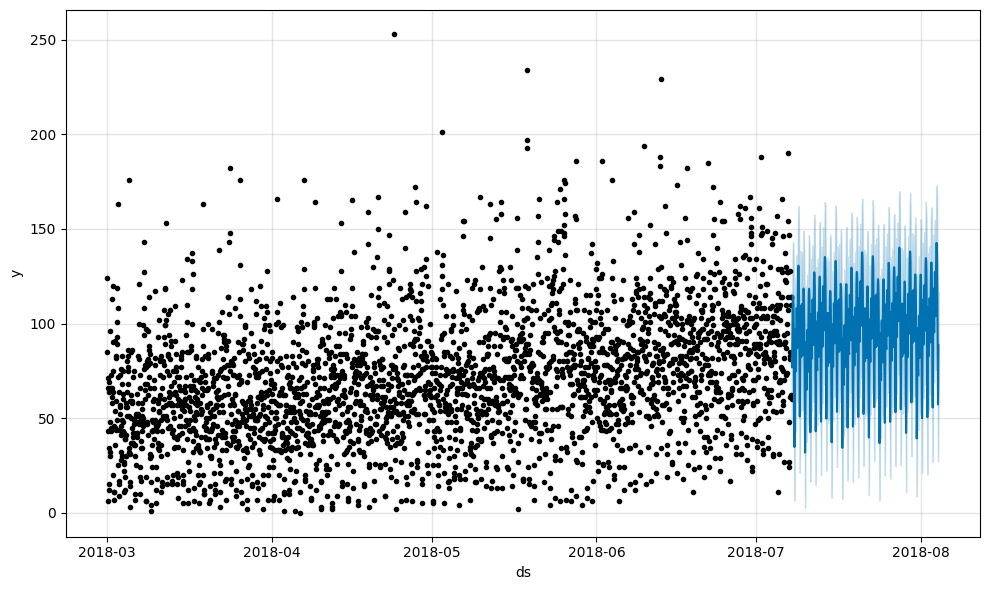

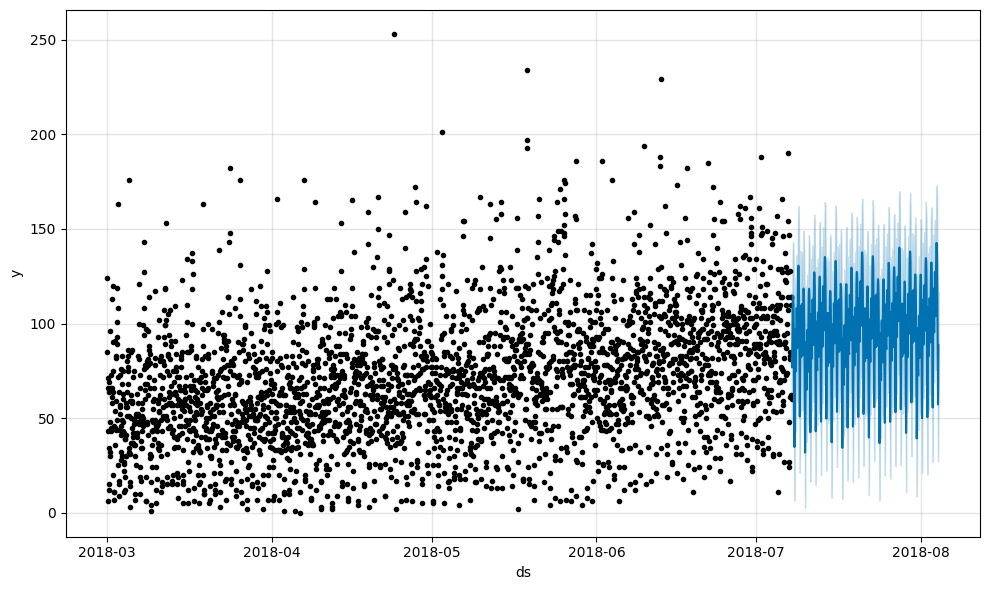

In [27]:
m.plot(forecast)

оно всё сделало за нас) класс не надо ручками смещения делать и тп)

In [28]:
forecast

ds       trend  yhat_lower  yhat_upper  trend_lower  \
0   2018-07-07 18:00:00   91.993145   52.237222  111.082201    91.993145   
1   2018-07-07 19:00:00   92.007967   48.940413  103.877263    92.007967   
2   2018-07-07 20:00:00   92.022789   56.042504  113.637251    92.022789   
3   2018-07-07 21:00:00   92.037610   68.828512  129.073702    92.037610   
4   2018-07-07 22:00:00   92.052432   80.557517  137.839039    92.052432   
..                  ...         ...         ...         ...          ...   
658 2018-08-04 04:00:00  101.745834   65.523184  122.254099   101.151205   
659 2018-08-04 05:00:00  101.760656   42.142257   99.474044   101.164102   
660 2018-08-04 06:00:00  101.775478   27.253880   85.519274   101.176999   
661 2018-08-04 07:00:00  101.790300   34.530713   95.946457   101.189896   
662 2018-08-04 08:00:00  101.805121   59.343332  116.722546   101.202794   

     trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0      91.993145      -10.485451            -10.485451            -10.485451   
1      92.007967      -15.211967            -15.211967            -15.211967   
2      92.022789       -7.706187             -7.706187             -7.706187   
3      92.037610        6.298952              6.298952              6.298952   
4      92.052432       17.734108             17.734108             17.734108   
..           ...             ...                   ...                   ...   
658   102.287618       -6.703277             -6.703277             -6.703277   
659   102.303494      -32.232673            -32.232673            -32.232673   
660   102.319371      -44.567893            -44.567893            -44.567893   
661   102.335247      -36.085369            -36.085369            -36.085369   
662   102.351124      -13.331309            -13.331309            -13.331309   

         daily  daily_lower  daily_upper    weekly  weekly_lower  \
0    -4.857398    -4.857398    -4.857398 -5.628054     -5.628054   
1    -8.910555    -8.910555    -8.910555 -6.301412     -6.301412   
2    -0.817176    -0.817176    -0.817176 -6.889011     -6.889011   
3    13.683164    13.683164    13.683164 -7.384212     -7.384212   
4    25.515567    25.515567    25.515567 -7.781458     -7.781458   
..         ...          ...          ...       ...           ...   
658 -14.109470   -14.109470   -14.109470  7.406193      7.406193   
659 -38.811578   -38.811578   -38.811578  6.578905      6.578905   
660 -50.261334   -50.261334   -50.261334  5.693442      5.693442   
661 -40.844650   -40.844650   -40.844650  4.759281      4.759281   
662 -17.117859   -17.117859   -17.117859  3.786550      3.786550   

     weekly_upper  multiplicative_terms  multiplicative_terms_lower  \
0       -5.628054                   0.0                         0.0   
1       -6.301412                   0.0                         0.0   
2       -6.889011                   0.0                         0.0   
3       -7.384212                   0.0                         0.0   
4       -7.781458                   0.0                         0.0   
..            ...                   ...                         ...   
658      7.406193                   0.0                         0.0   
659      6.578905                   0.0                         0.0   
660      5.693442                   0.0                         0.0   
661      4.759281                   0.0                         0.0   
662      3.786550                   0.0                         0.0   

     multiplicative_terms_upper        yhat  
0                           0.0   81.507694  
1                           0.0   76.795999  
2                           0.0   84.316601  
3                           0.0   98.336563  
4                           0.0  109.786540  
..                          ...         ...  
658                         0.0   95.042557  
659                         0.0   69.527983  
660                         0.0   57.207585  
661              

табличка , классная табличка)

сейчас посмотрим на предикт модели и сравним с реальными значениями 

In [29]:
decomposed = seasonal_decompose(y_valid)

In [30]:
df = forecast[['ds','yhat']].set_index(['ds'])
df

yhat
ds                             
2018-07-07 18:00:00   81.507694
2018-07-07 19:00:00   76.795999
2018-07-07 20:00:00   84.316601
2018-07-07 21:00:00   98.336563
2018-07-07 22:00:00  109.786540
...                         ...
2018-08-04 04:00:00   95.042557
2018-08-04 05:00:00   69.527983
2018-08-04 06:00:00   57.207585
2018-08-04 07:00:00   65.704931
2018-08-04 08:00:00   88.473812

[663 rows x 1 columns]

In [31]:
decomposed_1 = seasonal_decompose(df)

In [32]:
decomposed_1.trend

ds
2018-07-07 18:00:00   NaN
2018-07-07 19:00:00   NaN
2018-07-07 20:00:00   NaN
2018-07-07 21:00:00   NaN
2018-07-07 22:00:00   NaN
                       ..
2018-08-04 04:00:00   NaN
2018-08-04 05:00:00   NaN
2018-08-04 06:00:00   NaN
2018-08-04 07:00:00   NaN
2018-08-04 08:00:00   NaN
Name: trend, Length: 663, dtype: float64

In [33]:
decomposeddf = pd.DataFrame([decomposed_1.trend,decomposed.trend]).T
decomposeddf.columns = ['predict trend','trend'] 

In [34]:
decomposeddf

predict trend  trend
2018-07-07 18:00:00            NaN    NaN
2018-07-07 19:00:00            NaN    NaN
2018-07-07 20:00:00            NaN    NaN
2018-07-07 21:00:00            NaN    NaN
2018-07-07 22:00:00            NaN    NaN
...                            ...    ...
2018-08-04 04:00:00            NaN    NaN
2018-08-04 05:00:00            NaN    NaN
2018-08-04 06:00:00            NaN    NaN
2018-08-04 07:00:00            NaN    NaN
2018-08-04 08:00:00            NaN    NaN

[663 rows x 2 columns]

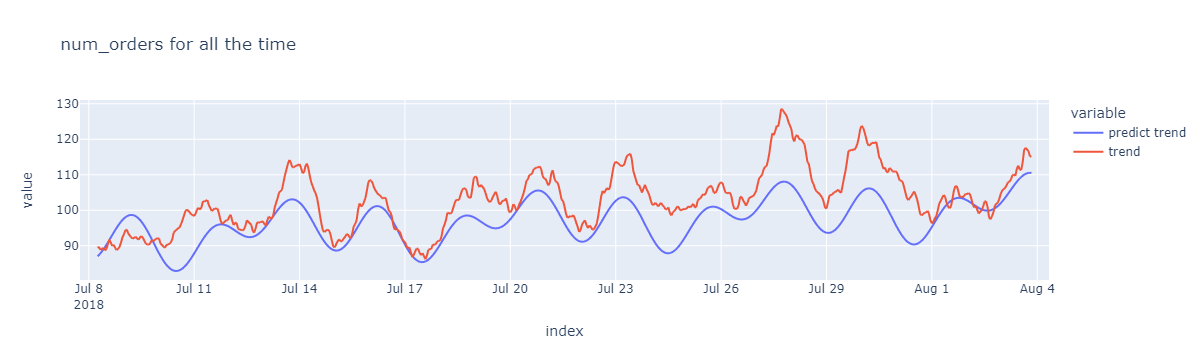

In [35]:
fig = px.line(decomposeddf,decomposeddf.index, y=['predict trend','trend'] , title='num_orders for all the time')
fig.show()

оно не уловило тренд , видна то что основная ошибка зарыта справа 

держи все данные которые нужно)

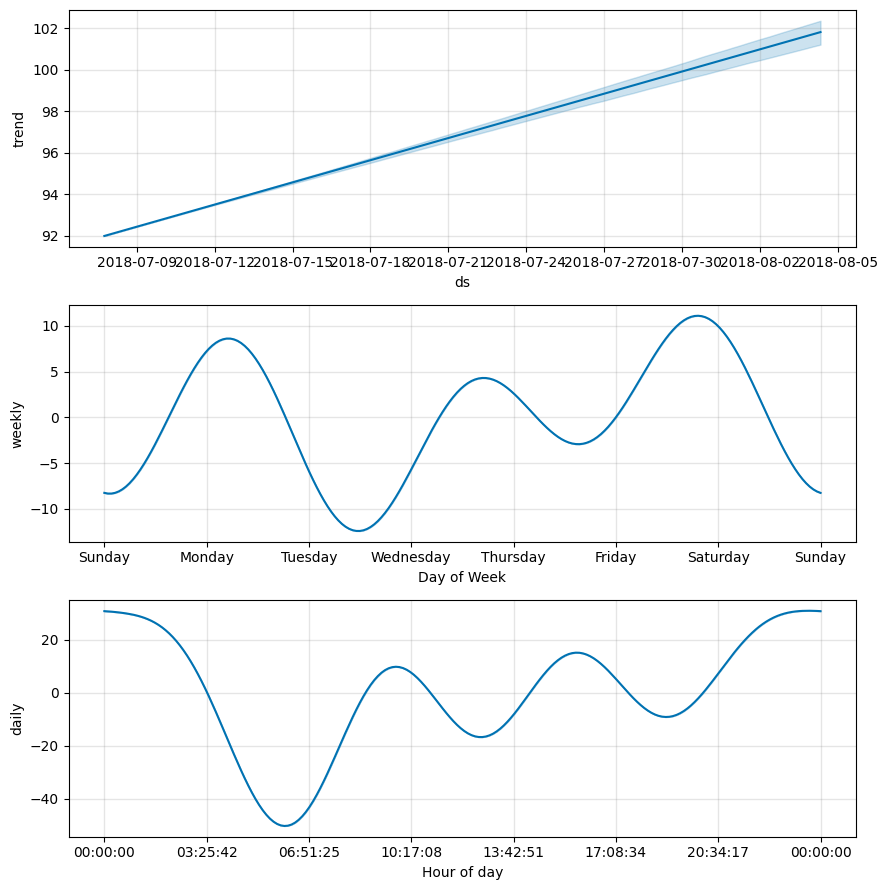

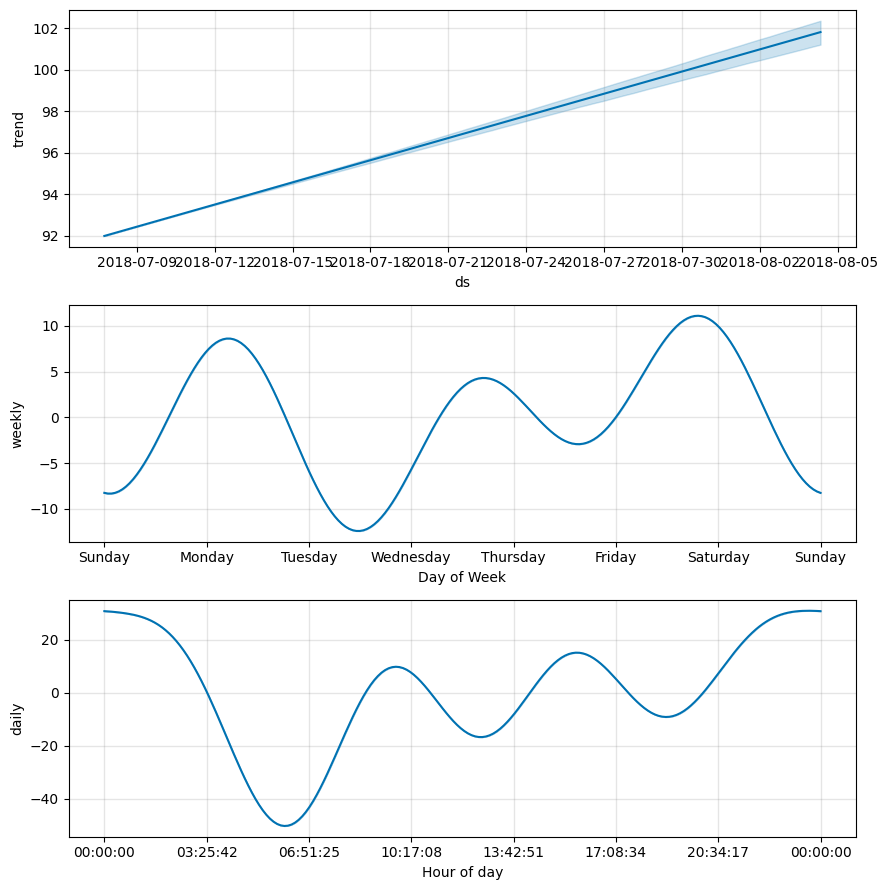

In [36]:
m.plot_components(forecast)

интересно , а профет определяет довольно плавно тренд) и пик действительно приходиться на ночь 

In [37]:
print(', '.join(forecast.columns))

ds, trend, yhat_lower, yhat_upper, trend_lower, trend_upper, additive_terms, additive_terms_lower, additive_terms_upper, daily, daily_lower, daily_upper, weekly, weekly_lower, weekly_upper, multiplicative_terms, multiplicative_terms_lower, multiplicative_terms_upper, yhat


In [38]:
np.sqrt(mean_squared_error(y_valid,forecast['yhat']))

29.477659317541356

ииии , ладно оптимизация так оптимизация...

In [39]:
m_test

ds    y
0   2018-07-07 18:00:00   52
1   2018-07-07 19:00:00   82
2   2018-07-07 20:00:00   76
3   2018-07-07 21:00:00   72
4   2018-07-07 22:00:00   91
..                  ...  ...
658 2018-08-04 04:00:00  131
659 2018-08-04 05:00:00   69
660 2018-08-04 06:00:00   45
661 2018-08-04 07:00:00   23
662 2018-08-04 08:00:00  120

[663 rows x 2 columns]

In [40]:
%%time
param_grid = {  
    'changepoint_prior_scale': np.linspace(0.001, 0.5, 6),
    'seasonality_prior_scale': np.linspace(0.01, 10.0, 6),
    'seasonality_mode': ['multiplicative']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

# Use cross validation to evaluate all parameters
def get_cv_validation_result(all_params):
    i = 0
    tuning_results = pd.DataFrame()
    for params in all_params:
        m = Prophet(changepoint_prior_scale = params['changepoint_prior_scale'],
                    seasonality_prior_scale = params['seasonality_prior_scale'],
                    seasonality_mode = params['seasonality_mode']).fit(m_train)
        df_cv = cross_validation(m, initial='14 days', period='28 days', horizon = '28 days', parallel="processes")
        # проверить результат по сравнению с использованием и без диапазона initial days
        
        df_p = performance_metrics(df_cv, rolling_window=1)
        print('Params:\n', params, '\n')
        print('Result:\n', df_p, '\n')
        # Объединяем результаты с набором параметров
        result = df_p.drop(columns=['horizon']).set_index(pd.Index([i]))
        result = result.join(pd.DataFrame(params, index=[i]))
        tuning_results = tuning_results.append(result)
        i += 1
    return tuning_results

tuning_results = get_cv_validation_result(all_params)

20:54:31 - cmdstanpy - INFO - Chain [1] start processing
20:54:31 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:27: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

20:54:33 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon          mse       rmse        mae     mdape     smape  coverage
0 28 days  5613.754978  74.924996  48.960622  0.336192  0.735217  0.612723 



20:54:33 - cmdstanpy - INFO - Chain [1] done processing


Params:
 {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 2.008, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon          mse       rmse        mae     mdape     smape  coverage
0 28 days  5521.139613  74.304371  47.277678  0.310657  0.711461  0.585193 



<timed exec>:27: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

20:54:36 - cmdstanpy - INFO - Chain [1] start processing
20:54:36 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:27: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

20:54:38 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 4.006, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon         mse       rmse        mae     mdape     smape  coverage
0 28 days  5529.05851  74.357639  47.464692  0.320366  0.713587  0.585193 



20:54:38 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:27: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

20:54:40 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 6.004, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon          mse       rmse        mae     mdape    smape  coverage
0 28 days  5536.222113  74.405794  47.458108  0.316436  0.71457  0.602307 



20:54:40 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:27: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

20:54:42 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 8.002, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon          mse       rmse        mae     mdape     smape  coverage
0 28 days  3476.039634  58.957948  38.941933  0.311643  0.672367  0.625372 



20:54:42 - cmdstanpy - INFO - Chain [1] done processing


Params:
 {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon         mse      rmse        mae     mdape     smape  coverage
0 28 days  3357.16406  57.94104  38.630134  0.322858  0.679536  0.609003 



<timed exec>:27: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

20:54:44 - cmdstanpy - INFO - Chain [1] start processing
20:54:45 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:27: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

20:54:47 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.1008, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon         mse       rmse        mae    mdape     smape  coverage
0 28 days  879.032157  29.648476  22.875228  0.25684  0.351896   0.77939 



20:54:47 - cmdstanpy - INFO - Chain [1] done processing


Params:
 {'changepoint_prior_scale': 0.1008, 'seasonality_prior_scale': 2.008, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon         mse       rmse        mae     mdape     smape  coverage
0 28 days  843.265133  29.039028  22.386274  0.270899  0.336838   0.68378 



<timed exec>:27: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

20:54:49 - cmdstanpy - INFO - Chain [1] start processing
20:54:49 - cmdstanpy - INFO - Chain [1] done processing


Params:
 {'changepoint_prior_scale': 0.1008, 'seasonality_prior_scale': 4.006, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon         mse       rmse        mae     mdape     smape  coverage
0 28 days  809.608141  28.453614  21.891223  0.266078  0.331101  0.685268 



<timed exec>:27: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

20:54:52 - cmdstanpy - INFO - Chain [1] start processing
20:54:52 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:27: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

20:54:54 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.1008, 'seasonality_prior_scale': 6.004, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon         mse       rmse        mae     mdape     smape  coverage
0 28 days  810.293587  28.465656  21.899248  0.265815  0.331316  0.690476 



20:54:54 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:27: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

20:54:56 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.1008, 'seasonality_prior_scale': 8.002, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon         mse       rmse        mae     mdape     smape  coverage
0 28 days  821.244774  28.657369  22.046468  0.267568  0.333522  0.685268 



20:54:56 - cmdstanpy - INFO - Chain [1] done processing


Params:
 {'changepoint_prior_scale': 0.1008, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon         mse       rmse        mae     mdape     smape  coverage
0 28 days  835.145423  28.898883  22.246417  0.267807  0.335105  0.695312 



<timed exec>:27: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

20:54:59 - cmdstanpy - INFO - Chain [1] start processing
20:54:59 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:27: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

20:55:01 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.2006, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon         mse       rmse        mae     mdape     smape  coverage
0 28 days  953.841669  30.884327  24.141875  0.271883  0.367081  0.755208 



20:55:01 - cmdstanpy - INFO - Chain [1] done processing


Params:
 {'changepoint_prior_scale': 0.2006, 'seasonality_prior_scale': 2.008, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon          mse       rmse        mae     mdape     smape  coverage
0 28 days  1049.979355  32.403385  25.001633  0.296662  0.365448  0.678943 



<timed exec>:27: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

20:55:03 - cmdstanpy - INFO - Chain [1] start processing
20:55:04 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:27: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

20:55:06 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.2006, 'seasonality_prior_scale': 4.006, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon         mse       rmse        mae     mdape     smape  coverage
0 28 days  1028.59175  32.071666  24.759192  0.294829  0.362909  0.684896 



20:55:06 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:27: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

20:55:08 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.2006, 'seasonality_prior_scale': 6.004, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon          mse      rmse        mae     mdape     smape  coverage
0 28 days  1024.862892  32.01348  24.719037  0.293465  0.362504  0.685268 



20:55:09 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:27: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

20:55:11 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.2006, 'seasonality_prior_scale': 8.002, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon          mse       rmse        mae     mdape     smape  coverage
0 28 days  1019.210783  31.925081  24.658124  0.292727  0.362487  0.684152 



20:55:11 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:27: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

20:55:13 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.2006, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon          mse       rmse        mae     mdape     smape  coverage
0 28 days  1050.398226  32.409848  24.995466  0.296393  0.365169  0.677827 



20:55:13 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:27: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

20:55:16 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.3004, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon         mse       rmse        mae     mdape     smape  coverage
0 28 days  967.747124  31.108634  24.370264  0.279443  0.369988  0.761161 



20:55:16 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:27: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

20:55:18 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.3004, 'seasonality_prior_scale': 2.008, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon          mse       rmse        mae     mdape     smape  coverage
0 28 days  2758.316353  52.519676  36.230895  0.340201  0.446405  0.643973 



20:55:19 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:27: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

20:55:21 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.3004, 'seasonality_prior_scale': 4.006, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon          mse       rmse        mae     mdape     smape  coverage
0 28 days  2772.582088  52.655314  36.331944  0.341174  0.446948  0.651414 



20:55:21 - cmdstanpy - INFO - Chain [1] done processing


Params:
 {'changepoint_prior_scale': 0.3004, 'seasonality_prior_scale': 6.004, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon          mse      rmse        mae     mdape     smape  coverage
0 28 days  2274.049004  47.68699  33.864224  0.338595  0.433264  0.664435 



<timed exec>:27: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

20:55:23 - cmdstanpy - INFO - Chain [1] start processing
20:55:24 - cmdstanpy - INFO - Chain [1] done processing


Params:
 {'changepoint_prior_scale': 0.3004, 'seasonality_prior_scale': 8.002, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon          mse       rmse       mae     mdape     smape  coverage
0 28 days  2704.323564  52.003111  36.00047  0.340622  0.445057   0.65997 



<timed exec>:27: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

20:55:26 - cmdstanpy - INFO - Chain [1] start processing
20:55:26 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:27: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

20:55:28 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.3004, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon          mse       rmse        mae     mdape     smape  coverage
0 28 days  2313.517296  48.099036  34.081889  0.338135  0.434391  0.664062 



20:55:29 - cmdstanpy - INFO - Chain [1] done processing


Params:
 {'changepoint_prior_scale': 0.4002, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon         mse       rmse        mae    mdape     smape  coverage
0 28 days  965.434339  31.071439  24.251054  0.28125  0.368504  0.761533 



<timed exec>:27: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

20:55:31 - cmdstanpy - INFO - Chain [1] start processing
20:55:31 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:27: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

20:55:33 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.4002, 'seasonality_prior_scale': 2.008, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon          mse       rmse        mae    mdape     smape  coverage
0 28 days  3440.545214  58.656161  39.386361  0.34966  0.464627  0.704613 



20:55:34 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:27: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

20:55:36 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.4002, 'seasonality_prior_scale': 4.006, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon          mse       rmse        mae     mdape     smape  coverage
0 28 days  3089.829836  55.586238  37.934517  0.347921  0.457348  0.707961 



20:55:36 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:27: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

20:55:39 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.4002, 'seasonality_prior_scale': 6.004, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon          mse       rmse        mae     mdape     smape  coverage
0 28 days  3493.432004  59.105262  39.587936  0.350086  0.465271  0.683036 



20:55:39 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:27: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

20:55:41 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.4002, 'seasonality_prior_scale': 8.002, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon          mse       rmse        mae    mdape     smape  coverage
0 28 days  3627.486566  60.228619  40.107183  0.34991  0.467701  0.683408 



20:55:42 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:27: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

20:55:44 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.4002, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon          mse       rmse        mae    mdape     smape  coverage
0 28 days  3583.225087  59.860046  39.927711  0.34984  0.466838  0.698661 



20:55:44 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:27: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

20:55:46 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon          mse       rmse       mae     mdape     smape  coverage
0 28 days  1004.637886  31.696023  24.91345  0.286376  0.376446  0.769345 



20:55:47 - cmdstanpy - INFO - Chain [1] done processing


Params:
 {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 2.008, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon          mse       rmse        mae     mdape     smape  coverage
0 28 days  4696.133505  68.528341  44.077009  0.357702  0.486194  0.752232 



<timed exec>:27: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

20:55:49 - cmdstanpy - INFO - Chain [1] start processing
20:55:49 - cmdstanpy - INFO - Chain [1] done processing


Params:
 {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 4.006, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon          mse       rmse       mae     mdape    smape  coverage
0 28 days  4810.752089  69.359585  44.38579  0.356022  0.48702  0.739583 



<timed exec>:27: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

20:55:52 - cmdstanpy - INFO - Chain [1] start processing
20:55:52 - cmdstanpy - INFO - Chain [1] done processing
<timed exec>:27: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

20:55:54 - cmdstanpy - INFO - Chain [1] start processing


Params:
 {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 6.004, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon          mse       rmse        mae     mdape     smape  coverage
0 28 days  4277.046739  65.399134  42.570468  0.352676  0.479102  0.750744 



20:55:55 - cmdstanpy - INFO - Chain [1] done processing


Params:
 {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 8.002, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon          mse       rmse        mae     mdape     smape  coverage
0 28 days  4120.044929  64.187576  41.960048  0.351764  0.475825   0.75186 



<timed exec>:27: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

20:55:57 - cmdstanpy - INFO - Chain [1] start processing
20:55:57 - cmdstanpy - INFO - Chain [1] done processing


Params:
 {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'} 

Result:
   horizon         mse       rmse       mae     mdape     smape  coverage
0 28 days  4061.49224  63.729838  41.81108  0.352479  0.476349  0.749628 

CPU times: total: 9.42 s
Wall time: 1min 28s


<timed exec>:27: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [41]:
tuning_results

mse       rmse        mae     mdape     smape  coverage  \
0   5613.754978  74.924996  48.960622  0.336192  0.735217  0.612723   
1   5521.139613  74.304371  47.277678  0.310657  0.711461  0.585193   
2   5529.058510  74.357639  47.464692  0.320366  0.713587  0.585193   
3   5536.222113  74.405794  47.458108  0.316436  0.714570  0.602307   
4   3476.039634  58.957948  38.941933  0.311643  0.672367  0.625372   
5   3357.164060  57.941040  38.630134  0.322858  0.679536  0.609003   
6    879.032157  29.648476  22.875228  0.256840  0.351896  0.779390   
7    843.265133  29.039028  22.386274  0.270899  0.336838  0.683780   
8    809.608141  28.453614  21.891223  0.266078  0.331101  0.685268   
9    810.293587  28.465656  21.899248  0.265815  0.331316  0.690476   
10   821.244774  28.657369  22.046468  0.267568  0.333522  0.685268   
11   835.145423  28.898883  22.246417  0.267807  0.335105  0.695312   
12   953.841669  30.884327  24.141875  0.271883  0.367081  0.755208   
13  1049.979355  32.403385  25.001633  0.296662  0.365448  0.678943   
14  1028.591750  32.071666  24.759192  0.294829  0.362909  0.684896   
15  1024.862892  32.013480  24.719037  0.293465  0.362504  0.685268   
16  1019.210783  31.925081  24.658124  0.292727  0.362487  0.684152   
17  1050.398226  32.409848  24.995466  0.296393  0.365169  0.677827   
18   967.747124  31.108634  24.370264  0.279443  0.369988  0.761161   
19  2758.316353  52.519676  36.230895  0.340201  0.446405  0.643973   
20  2772.582088  52.655314  36.331944  0.341174  0.446948  0.651414   
21  2274.049004  47.686990  33.864224  0.338595  0.433264  0.664435   
22  2704.323564  52.003111  36.000470  0.340622  0.445057  0.659970   
23  2313.517296  48.099036  34.081889  0.338135  0.434391  0.664062   
24   965.434339  31.071439  24.251054  0.281250  0.368504  0.761533   
25  3440.545214  58.656161  39.386361  0.349660  0.464627  0.704613   
26  3089.829836  55.586238  37.934517  0.347921  0.457348  0.707961   
27  3493.432004  59.105262  39.587936  0.350086  0.465271  0.683036   
28  3627.486566  60.228619  40.107183  0.349910  0.467701  0.683408   
29  3583.225087  59.860046  39.927711  0.349840  0.466838  0.698661   
30  1004.637886  31.696023  24.913450  0.286376  0.376446  0.769345   
31  4696.133505  68.528341  44.077009  0.357702  0.486194  0.752232   
32  4810.752089  69.359585  44.385790  0.356022  0.487020  0.739583   
33  4277.046739  65.399134  42.570468  0.352676  0.479102  0.750744   
34  4120.044929  64.187576  41.960048  0.351764  0.475825  0.751860   
35  4061.492240  63.729838  41.811080  0.352479  0.476349  0.749628   

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  
0                    0.0010                    0.010   multiplicative  
1                    0.0010                    2.008   multiplicative  
2                    0.0010                    4.006   multiplicative  
3                    0.0010                    6.004   multiplicative  
4                    0.0010                    8.002   multiplicative  
5                    0.0010                   10.000   multiplicative  
6                    0.1008                    0.010   multiplicative  
7                    0.1008                    2.008   multiplicative  
8                    0.1008                    4.006   multiplicative  
9                    0.1008                    6.004   multiplicative  
10                   0.1008                    8.002   multiplicative  
11                   0.1008                   10.000   multiplicative  
12                   0.2006                    0.010   multiplicative  
13                   0.2006                    2.008   multiplicative  
14                   0.2006                    4.006   multiplicative  
15                   0.2006                    6.004   multiplicative  
16                   0.2006                    8.002   multiplicative  
17                   0.2006                   10.000   multiplicative  
18              

опа 26 лучше 48)

In [42]:
best_params = all_params[np.argmin(tuning_results['rmse'])]
print('Минимальное MAE = ', tuning_results.loc[np.argmin(tuning_results['rmse'])].mae,'\n')
print('Параметры лучшей модели:', best_params)

Минимальное MAE =  21.891223253799055 

Параметры лучшей модели: {'changepoint_prior_scale': 0.1008, 'seasonality_prior_scale': 4.006, 'seasonality_mode': 'multiplicative'}


In [43]:
best_params

{'changepoint_prior_scale': 0.1008,
 'seasonality_prior_scale': 4.006,
 'seasonality_mode': 'multiplicative'}

In [44]:
best_model = Prophet(**best_params)

20:55:59 - cmdstanpy - INFO - Chain [1] start processing
20:55:59 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Алексей\AppData\Local\Temp\ipykernel_1832\4029412793.py:7: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.

C:\Users\Алексей\AppData\Local\Temp\ipykernel_1832\4029412793.py:8: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



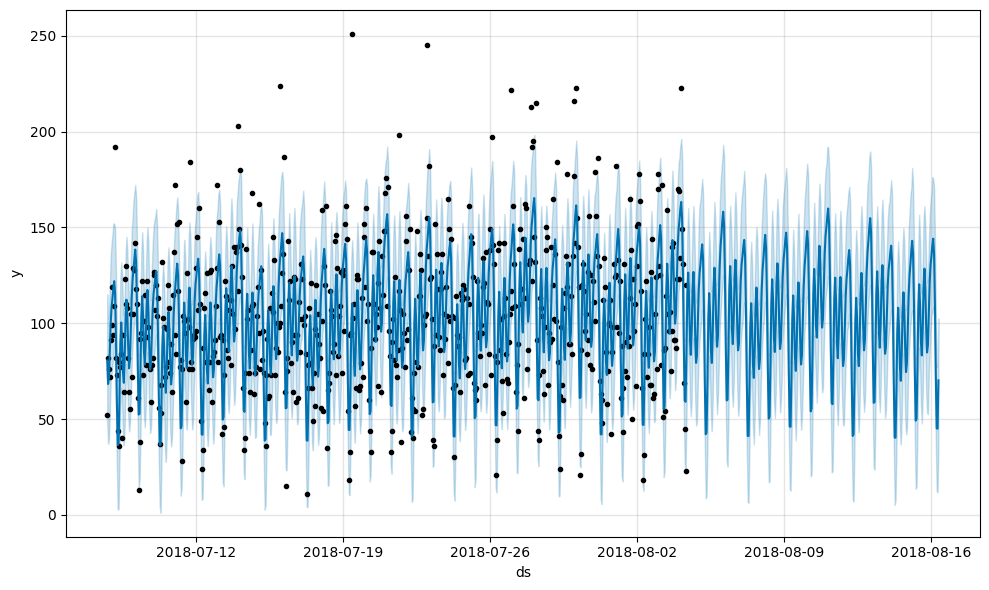

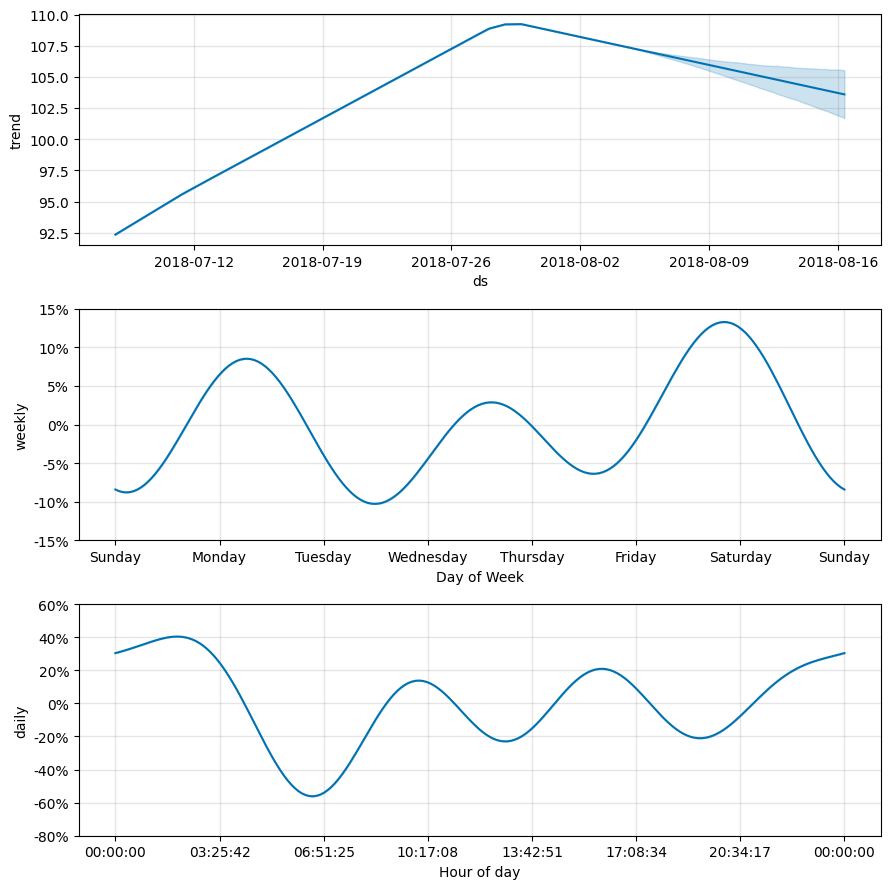

In [45]:
best_model.fit(m_test)
future = best_model.make_future_dataframe(periods=144*2, freq='1H')
forecast = best_model.predict(future)
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(m_test.set_index('ds'))
plot1 = best_model.plot(forecast)
plot2 = best_model.plot_components(forecast)
plot1.show()
plot2.show()

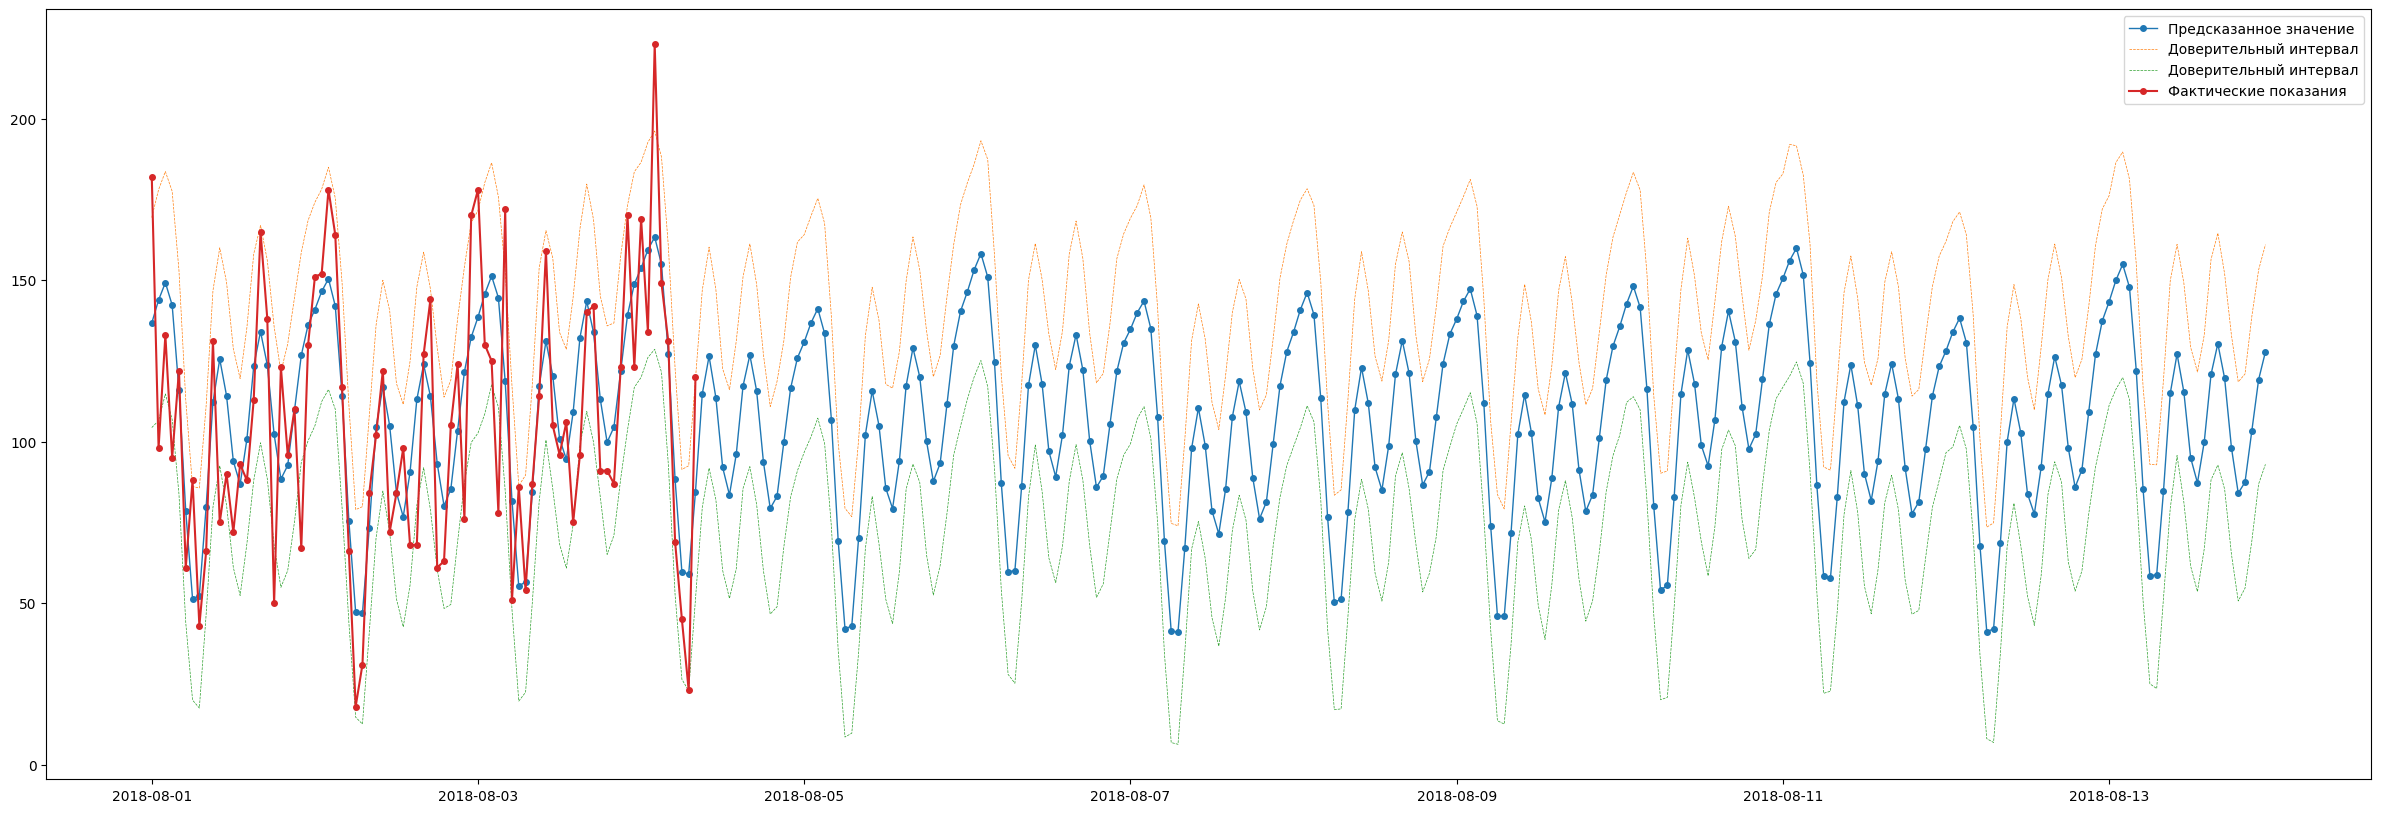

In [46]:
start, end = '2018-08-01 0:00', '2018-08-13 23:50'
fig, ax = plt.subplots()
fig.set_figwidth(30)
fig.set_figheight(10)
ax.plot(cmp_df['yhat'].loc[start:end], marker='.', linestyle='-', markersize=8, linewidth=1, label='Предсказанное значение')
ax.plot(cmp_df[['yhat_upper','yhat_lower']].loc[start:end], linestyle='--', linewidth=0.5, label='Доверительный интервал')
ax.plot(cmp_df.loc[start:end].y , marker='o', markersize=4, linestyle='-', label='Фактические показания')
ax.legend();

нннууу в целом не плохо) иногда из доверительно интервала выходит , но в целом тенденцию модель распознала

20:56:01 - cmdstanpy - INFO - Chain [1] start processing
20:56:01 - cmdstanpy - INFO - Chain [1] done processing


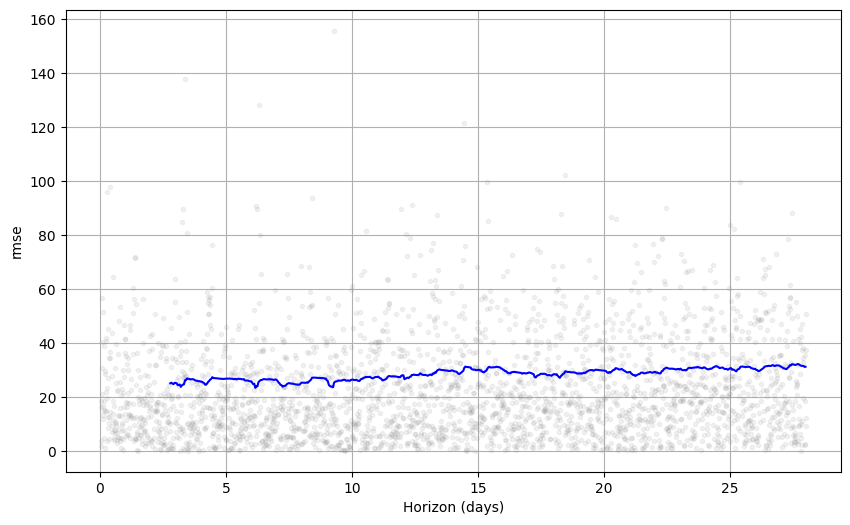

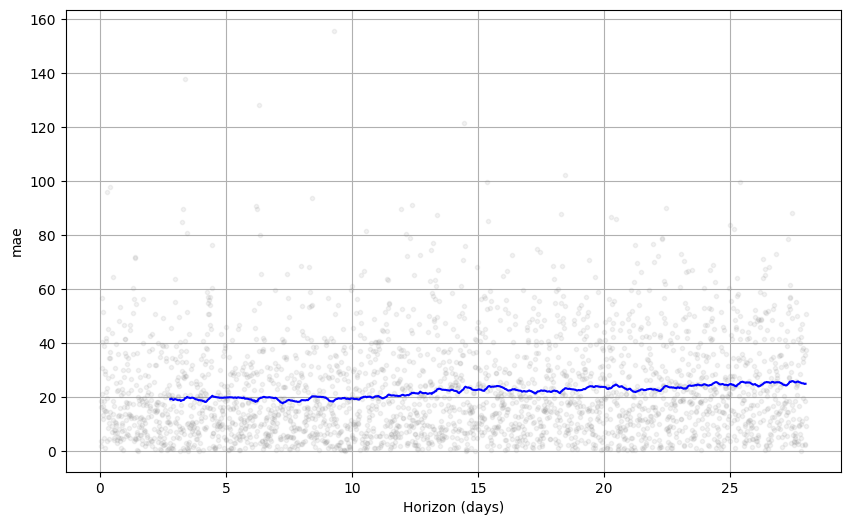

In [47]:
best_model = Prophet(**best_params)
all_data_to_train=y_train.reset_index()
all_data_to_train.columns = ['ds', 'y']
best_model.fit(all_data_to_train)
df_cv = cross_validation(best_model, initial='14 days', period='28 days', horizon = '28 days', parallel="processes")
fig1 = plot_cross_validation_metric(df_cv, metric='rmse')
fig2 = plot_cross_validation_metric(df_cv, metric='mae')

видим что rmse имеет цикличность => не очень хорошо обучили модель , но на этом с этой моделью всё. В идеале надо ещё покапаться но мы не на работе)

новый день новая модель , освежили память а теперь давайте rnn модель посмотрим))

In [48]:
scaler = MinMaxScaler()

In [49]:
scaler.fit(y_train)
scaled_train = scaler.transform(y_train)
scaled_test = scaler.transform(y_valid)

In [50]:
scaled_test[:10]

array([[0.2055336 ],
       [0.32411067],
       [0.30039526],
       [0.28458498],
       [0.35968379],
       [0.47035573],
       [0.39130435],
       [0.3715415 ],
       [0.43083004],
       [0.75889328]])

In [51]:
n_input = 25
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [52]:
X,y = generator[0]
X.flatten()

array([0.49011858, 0.33596838, 0.28063241, 0.26086957, 0.16996047,
       0.02371542, 0.04743083, 0.05928854, 0.13438735, 0.27272727,
       0.25296443, 0.37944664, 0.11857708, 0.12648221, 0.18972332,
       0.26086957, 0.16996047, 0.17391304, 0.28853755, 0.17786561,
       0.24110672, 0.26086957, 0.44664032, 0.22924901, 0.35573123])

In [53]:
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [54]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 150)               91200     
                                                                 
 dense (Dense)               (None, 1)                 151       
                                                                 
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [55]:
model.fit(generator,epochs=35)

Epoch 1/35
3065/3065 [==============================] - 14s 4ms/step - loss: 0.0156
Epoch 2/35
3065/3065 [==============================] - 14s 5ms/step - loss: 0.0136
Epoch 3/35
3065/3065 [==============================] - 13s 4ms/step - loss: 0.0134
Epoch 4/35
3065/3065 [==============================] - 18s 6ms/step - loss: 0.0126
Epoch 5/35
3065/3065 [==============================] - 17s 6ms/step - loss: 0.0120
Epoch 6/35
3065/3065 [==============================] - 16s 5ms/step - loss: 0.0114
Epoch 7/35
3065/3065 [==============================] - 15s 5ms/step - loss: 0.0108
Epoch 8/35
3065/3065 [==============================] - 13s 4ms/step - loss: 0.0100
Epoch 9/35
3065/3065 [==============================] - 15s 5ms/step - loss: 0.0095
Epoch 10/35
3065/3065 [==============================] - 13s 4ms/step - loss: 0.0089
Epoch 11/35
3065/3065 [==============================] - 13s 4ms/step - loss: 0.0086
Epoch 12/35
3065/3065 [==============================] - 14s 4ms/step - lo

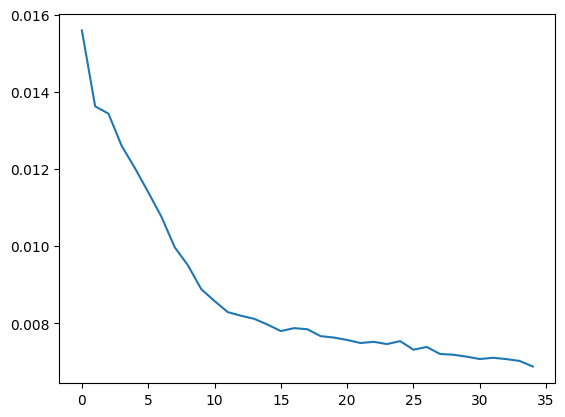

In [56]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [57]:
last_train_batch = scaled_train[-25:]

In [58]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [59]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 146ms/step


array([[0.3178447]], dtype=float32)

In [60]:
scaled_test[0]

array([0.2055336])

In [61]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(y_test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 15ms/step


In [62]:
true_predictions = scaler.inverse_transform(test_predictions)

In [63]:
y_valid['Predictions'] = true_predictions

<AxesSubplot: xlabel='datetime'>

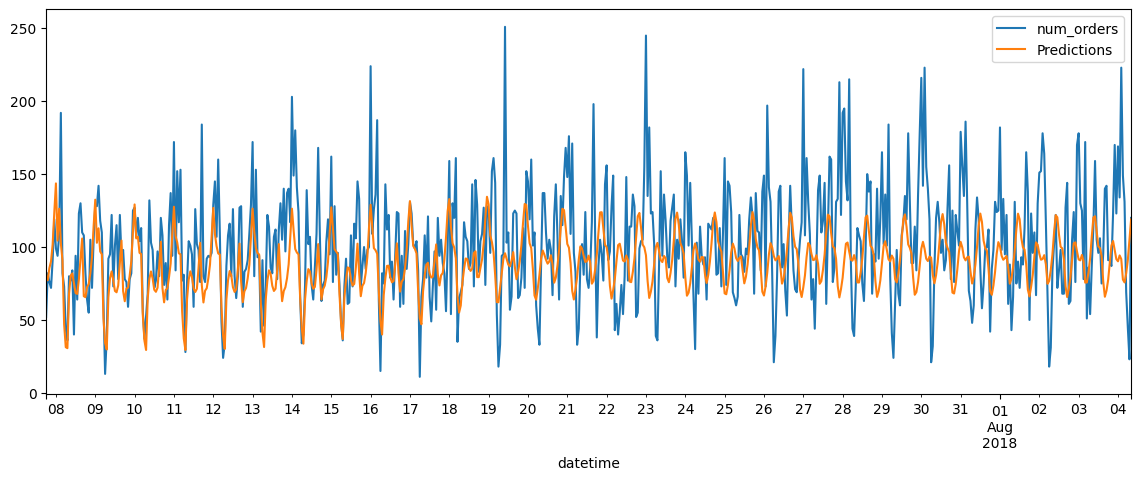

In [64]:
y_valid.plot(figsize=(14,5))

опять тренд не распознал 

In [65]:
y_valid

num_orders  Predictions
datetime                                    
2018-07-07 18:00:00          52    80.414706
2018-07-07 19:00:00          82    77.197348
2018-07-07 20:00:00          76    85.511783
2018-07-07 21:00:00          72    90.124371
2018-07-07 22:00:00          91   101.816117
...                         ...          ...
2018-08-04 04:00:00         131    75.723522
2018-08-04 05:00:00          69    81.895092
2018-08-04 06:00:00          45    90.951960
2018-08-04 07:00:00          23   104.757541
2018-08-04 08:00:00         120   118.923775

[663 rows x 2 columns]

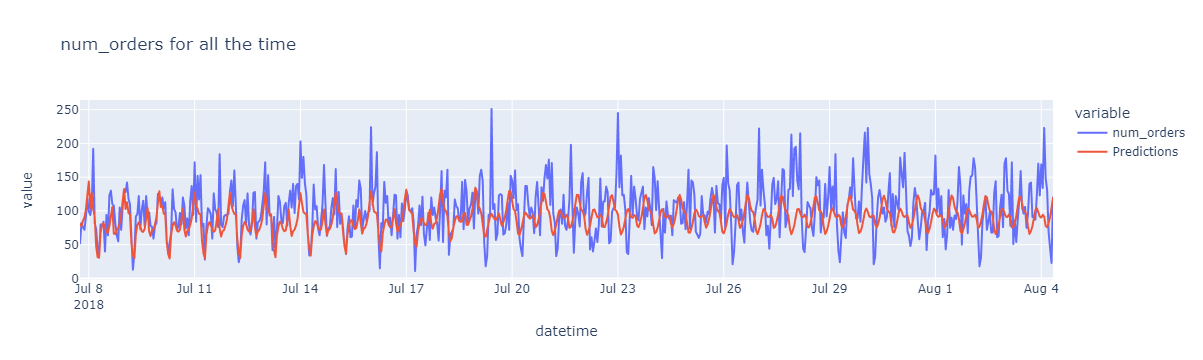

In [66]:
fig = px.line(y_valid,y_valid.index, y=['num_orders',"Predictions"], title='num_orders for all the time')
fig.show()

In [67]:
rmse=sqrt(mean_squared_error(y_valid['num_orders'],y_valid['Predictions']))
rmse

39.645641095158844

rmse 39 , не так хорошо как ожидалось ,но проблема в не статичности ряда + малом количестве данных, но это уже не важно) я попробовал rnn (и многослойный) надо лучше в нём разобраться) 

## Тестирование

In [68]:
best_model = Prophet(**best_params)

In [69]:
m_trava = y_tra_va.reset_index()
m_trava.columns = ['ds', 'y']
m_test = y_test.reset_index()
m_test.columns = ['ds', 'y']

In [70]:
best_model.fit(m_trava)

21:04:31 - cmdstanpy - INFO - Chain [1] start processing
21:04:31 - cmdstanpy - INFO - Chain [1] done processing


In [71]:
forecast_test = best_model.predict(m_test)

In [72]:
from sklearn.metrics import mean_squared_error

In [73]:
np.sqrt(mean_squared_error(m_test['y'], forecast_test['yhat']))

41.819133474873205

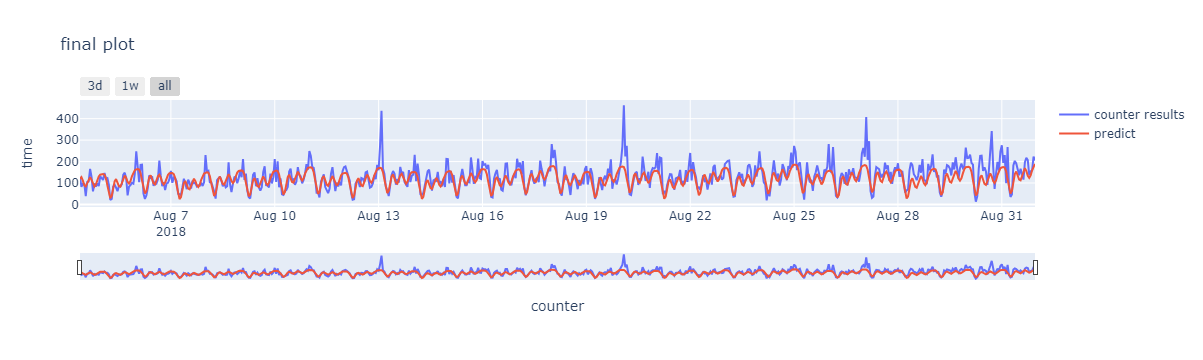

In [74]:
x_data1 = m_test['ds']
x_data2 = m_test['ds']

y_data_1 = m_test['y']
y_data_2 = forecast_test['yhat']

# Create traces for each data set
trace1 = go.Scatter(x=x_data1, y=y_data_1, mode='lines', name='counter results')
trace2 = go.Scatter(x=x_data2, y=y_data_2, mode='lines', name='predict')


# Create the figure and add traces
fig = go.Figure()
fig.add_trace(trace1)
fig.add_trace(trace2)

# Update layout if needed (e.g., title, axis labels)
fig.update_layout(title='final plot',
                  xaxis_title='counter',
                  yaxis_title='time')
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=3, label="3d", step="day", stepmode="backward"),
            dict(count=7, label="1w", step="day", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

<b>вывод:</b>
<br>по результату работы с временным рядом было задетектировано 4 аномалии 
<br>итог эксперементов с моделями:профет показал лучший результат с rmse в 30 
<br>рекомендации бизнесу: проблем нет 